In [ ]:
from google.colab import drive

# Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Classification Report with Improved Model:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        96
           1       0.93      0.98      0.95        54

    accuracy                           0.97       150
   macro avg       0.96      0.97      0.96       150
weighted avg       0.97      0.97      0.97       150



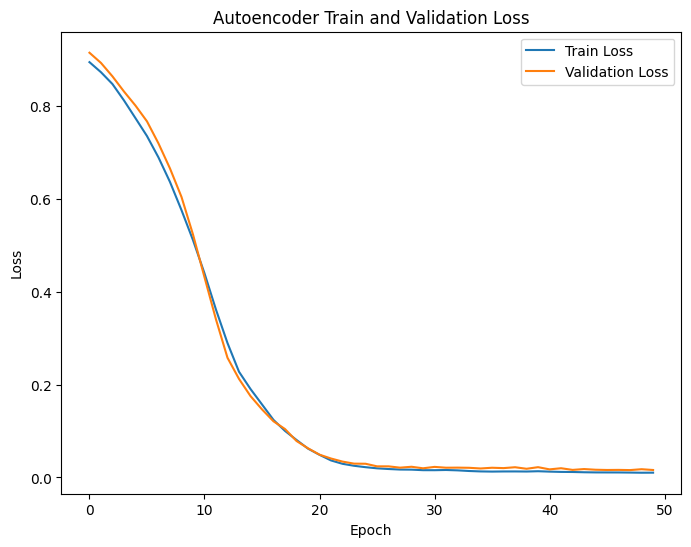

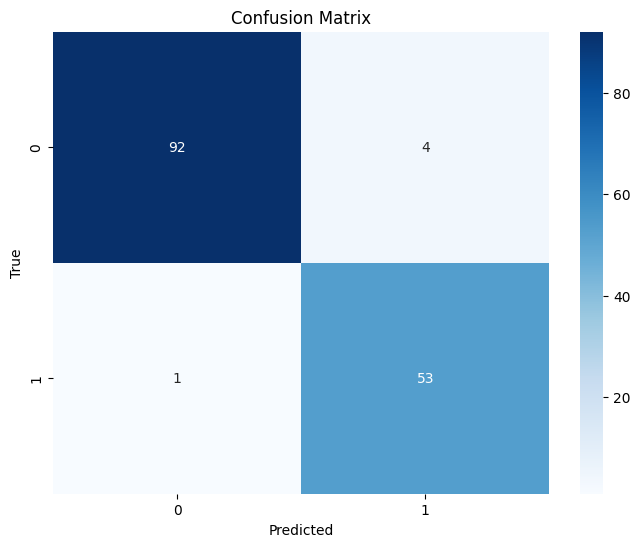

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (replace with your actual data paths)
pni_data = pd.read_csv('/content/drive/MyDrive/pni_500.csv')
telemetry_data = pd.read_csv('/content/drive/MyDrive/telemetry_500.csv')

# Pivot pni_data to get segment lengths as columns
pni_pivot = pni_data.pivot(index='RouteID', columns='Segment', values='cableLength').fillna(0)
pni_pivot.columns = [f'segment{int(col)}_length' for col in pni_pivot.columns]

# Merge with telemetry data
data = telemetry_data.merge(pni_pivot, on='RouteID', how='left')

# Define features and target
features = [col for col in data.columns if col.startswith('segment') or col == 'distanceMeasured']
X = data[features]
y = data['label']

# Split into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Select normal samples (label=0) from training set for autoencoder
X_train_normal = X_train_scaled[y_train == 0]

# Split normal data into train and validation for autoencoder
X_train_normal_train, X_train_normal_val = train_test_split(X_train_normal, test_size=0.2, random_state=42)

# Define a deeper autoencoder
input_dim = X_train_scaled.shape[1]
encoding_dim = 8  # Increased bottleneck size
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder with validation
history = autoencoder.fit(X_train_normal_train, X_train_normal_train,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(X_train_normal_val, X_train_normal_val),
                          verbose=0)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('autoencoder_loss.png')

# Extract encoded features
encoder = Model(input_layer, encoded)
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

# Compute reconstruction error
X_train_reconstructed = autoencoder.predict(X_train_scaled)
X_test_reconstructed = autoencoder.predict(X_test_scaled)
reconstruction_error_train = np.mean(np.square(X_train_scaled - X_train_reconstructed), axis=1).reshape(-1, 1)
reconstruction_error_test = np.mean(np.square(X_test_scaled - X_test_reconstructed), axis=1).reshape(-1, 1)

# Augment the dataset with encoded features and reconstruction error
X_train_augmented = np.hstack((X_train_scaled, X_train_encoded, reconstruction_error_train))
X_test_augmented = np.hstack((X_test_scaled, X_test_encoded, reconstruction_error_test))

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_augmented, y_train)
best_rf_model = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_rf_model.predict(X_test_augmented)
print("Classification Report with Improved Model:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')